파이썬 머신러닝 완벽 가이드 개정2판
ch8.10-11
 p.566-583

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 8. 텍스트 분석
## 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

https://www.kaggle.com/competitions/mercari-price-suggestion-challenge

일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제
- 데이터 세트 : 제품에 대한 여러 속성 및 제품 설명 등의 텍스틑 데이터
- 제품의 예측 가격을 판매자에게 제공할 수 있음

- train_id : 데이터 id
- name : 제품명
- item_condition_id : 판매자가 제공하는 제품 상태
- category_naem : 카테고리 명
- brand_name : 브랜드 이름
- price : 제품 가격, 예측을 위한 타깃 속성
- shipping : 배송비 무료 여부. 1이면 무료, 0이면 유료
- item_description : 제품에 대한 설명

=> price: 타깃 값
회귀로 피처를 학습한 뒤 price를 예측

### [데이터 전처리]


In [2]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/2025-1/2025-1 ESAA OB/과제/data/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


-> 1482535개의 레코드를 가지고 있는 데이터 세트

In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


Null 데이터 존재 -> 이후에 적절한 문자열로 치환하기



**Target 값인 price 칼럼**

데이터 분포도 살펴보기

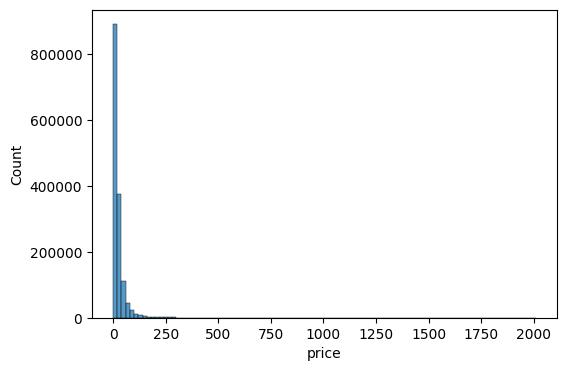

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

로그 변환하기

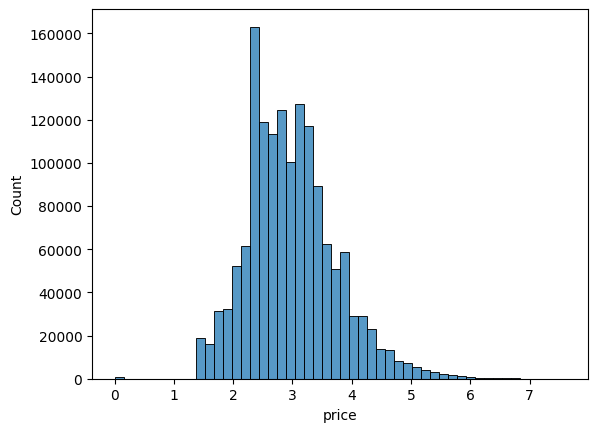

In [5]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

-> 비교적 정규 분포에 가까운 데이터를 이룸

In [6]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


**shipping과 item_condition_id**

In [7]:
print('Shipping 값 유형 : \n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형 : \n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형 : 
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형 : 
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64



- Shipping : 배송비 유무, 값이 비교적 균일
- Item_condition_id : 판매자가 제공하는 제품 상태, 1, 2, 3 값이 주를 이룸

**item_description**

In [8]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

np.int64(82489)

- 별도 설명이 없는 경우 'No descrioption yet' 값으로 돼 있음


**category_name**

- '/'로 분리된 카테고리를 하나의 문자열로 나타냄
- 'Men/Tops/T-shirts' : 대분류 'Men', 중분류 'Tops', 소분류 'T-shirts'

In [9]:
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형:
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수: 114
소분류 개수: 871


In [10]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['catergory_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 함
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,6327
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


### [피처 인코딩과 피처 벡터화]
선형 회귀 모델과 회귀 트리 모델 모두 적용
- 원-핫 인코딩 적용
- 피처 벡터화
  * 짧은 텍스트 : Count 기반의 벡터화
  * 긴 텍스트 : TD-IDF 기반의 벡터화



**brand_name**

: 상품의 브랜드명

In [11]:
print('brand name 의 유형 건수 : ', mercari_df['brand_name'].nunique())
print('brand name sample 5건 :\n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 :  4810
brand name sample 5건 :
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


- 명료한 문자열로 돼 있음
- 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환 적용하기
- 원-핫 인코딩 변환

**name**

: 상품명

In [12]:
print('name 의 종류 개수 :', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name 의 종류 개수 : 1225273
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


- 거의 고유한 상품명
- Count 기반으로 피처 벡터화 변환 적용하기

**category_name**

- cat_dae, cat_jung, cat_so 칼럼
- 원-핫 인코딩

**shipping**

- 0과 1 두 가지 유형
- 원-핫 인코딩

**item_condition**

- 1,2,3,4,5 다섯 가지 유형의 값
- 원-핫 인코딩

**item_description**

: 상품에 대한 간단 설명

- 데이터 세트에서 가장 긴 텍스트
- 평균 문자열 크기와 2개 정도의 텍스트만 추출하기

In [13]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


- 평균 문자열이 145자
- TF-IDF 변환하기

**주요 칼럼 인코딩 및 피처 벡터화 변환하기**
- name, item_description 칼럼을 피처 벡터화
 * name : CountVectorizer 변환
 * item_description : TfidfVectorizer 변환


In [14]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태
- 인코딩 대성 칼럼을 희소 행렬 형태로 인코딩 적용한 후, 함께 결합하기
- 사이킷런이 원-핫 인코딩을 위해 OneHotEncoder, LabelBinarizer 클래스를 제공

In [15]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)

X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output = True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output = True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output = True)
X_cat_jung = lb_cat_dae.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output = True)
X_cat_so = lb_cat_dae.fit_transform(mercari_df['cat_so'])

In [16]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shpae:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shpae:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shpae:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shpae:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shpae:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shpae:(1482535, 114), X_cat_so shape:(1482535, 871)


- 인코딩 변환된 데이터 세트 : CSR 형태로 변환된 csr_matrix 타입
- 인코딩으로 변환하며 인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열을 가지는 벡터 형태의 많은 칼럼과 결합되므로 문제되지 않음

**피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 결합하기**
- hstack() 이용

In [17]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_dae)

# hstack 함술르 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 160709)


0

- csr_matrix 타입

### [릿지 회귀 모델 구축 및 평가]

평가 지표 RMSLE 방식
- RMSLE : 오류 값에 로그를 취해 RMSE를 구하는 방식
- 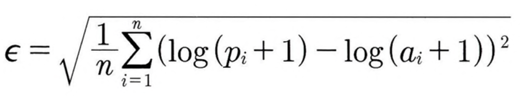

In [18]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred),2)))

def evaluate_org_price(y_test, preds):
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

학습용 데이터 생성하고 모델을 학습/예측하는 로직을 함수로 만들기

In [19]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

Ridge를 이용해 Mercari Price의 회귀 예측을 수행하기

In [20]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))


Item Description을 제외했을 때 rmsle 값: 0.4983990938999374
Item Description을 포함한 rmsle 값: 0.4680432471796771


- Item Description 을 포함했을 때 rmsle 값이 많이 감소함

### [LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가]

LightGBM을 이용해 회귀를 수행

-> 릿지 모델 예측값과 LightGBM 모델 에측값을 간단한 앙상블 방식으로 섞어서 최종 회귀 예측값 평가

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
# lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
# print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# preds = lgbm_preds * 0.45 + linear_preds * 0.55
# print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))